# STAT207 Mini-Project #2 - Predicting Out-of-State Tuition for Midwestern Colleges

Sahil Sangani

In [1]:
#Imports here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## 1. Introduction

The primary goal is to build a predictive model that will effectively predict out-of-state tuition for colleges in the Midwestern United States. The model uses attributes such as state, institude type, degree length, room and board cost, and in-state tuition to predict out-of-state tuition costs for colleges that may not have been seen during training. A secondary goal is to gain interpretative insignts about how these variables influence out-of-state tuition, allowing users to understand which factors are most strongly associated with tuition costs.

<br> This model can be useful to two groups:
1. High school students and their colege counselors or advisors can benefit by using this model to shortlist schools that align with their financial situations and state preference. Families considering schools out-of-state, can use the model to get quick, data-driven estimates of tuition to prepare in advance.
2. Colleges looking to adjust their out-of-state tuition prices to be competitive with other similar colleges, or to control the enrollment of out-of-state students. 



## 2. Dataset Discussion

This dataset is made by Jesse Mostipak who collected the information from various college websites, like TuitionTracker.org, Chronicle of Higher Education, Pricenomics, payscale.com etc. The Dataset was last updated 5 years ago, so there could be colleges not included in this dataset.

[This](https://www.kaggle.com/datasets/jessemostipak/college-tuition-diversity-and-pay?select=tuition_cost.csv) is where I downloaded this csv file from on 01/04/2025.

In [2]:
df = pd.read_csv('tuition_cost.csv')
df.head()

,name,state,state_code,type,degree_length,room_and_board,in_state_tuition,in_state_total,out_of_state_tuition,out_of_state_total
0,Aaniiih Nakoda College,Montana,MT,Public,2 Year,NaN,2380,2380,2380,2380
1,Abilene Christian University,Texas,TX,Private,4 Year,10350.0,34850,45200,34850,45200
2,Abraham Baldwin Agricultural College,Georgia,GA,Public,2 Year,8474.0,4128,12602,12550,21024
3,Academy College,Minnesota,MN,For Profit,2 Year,NaN,17661,17661,17661,17661
4,Academy of Art University,California,CA,For Profit,4 Year,16648.0,27810,44458,27810,44458


In [3]:
print('Number of rows:', df.shape[0])

Number of rows: 2973


## 3. Dataset Cleaning

This dataset originally contains colleges from all 50 states + Puerto Rico. I am narrowing it down to only the colleges located in the 12 states of Midwest U.S. as limiting the dataset to a smaller region allows for a more focused and accurate model. Doing so leaves us with 776 unique colleges.

In [4]:
# list of states in mid west 
mid_west = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']

# Remove all schools that are not in mid west states
df = df[ df.state.isin(mid_west)]
df.shape[0]

776

Removing these columns because `state_code` is just the abbreviation for `state` column, and `in_state_total` and `out_of_state_total` are sum of corresponsing tuition and `room_and_board` costs.

In [5]:
# Remove columns not needed
df = df.drop(['state_code', 'in_state_total', 'out_of_state_total'], axis=1)
df.head()

,name,state,type,degree_length,room_and_board,in_state_tuition,out_of_state_tuition
3,Academy College,Minnesota,For Profit,2 Year,NaN,17661,17661
8,Adrian College,Michigan,Private,4 Year,11318.0,37087,37087
24,Albion College,Michigan,Private,4 Year,12380.0,45775,45775
28,Alexandria Technical and Community College,Minnesota,Public,2 Year,NaN,5416,5416
33,Allegheny Wesleyan College,Ohio,Private,4 Year,4000.0,6400,6400


`room_and_board` column has missing values, this could be because the college might not offer on-campus housing, or could be incomplete data. From the box plot below, we can see that there is a association between `state` and `room_and_board`, as expected. I will use the median `room_and_board` price of the state to fill the missing values, because in the case where college does not offer on-campus housing, out-of-state students would need to get a housing option in that state.

In [6]:
df.isna().sum()

name                      0
state                     0
type                      0
degree_length             0
room_and_board          282
in_state_tuition          0
out_of_state_tuition      0
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Minnesota'),
  Text(1, 0, 'Michigan'),
  Text(2, 0, 'Ohio'),
  Text(3, 0, 'Iowa'),
  Text(4, 0, 'Kansas'),
  Text(5, 0, 'Wisconsin'),
  Text(6, 0, 'Illinois'),
  Text(7, 0, 'Indiana'),
  Text(8, 0, 'South Dakota'),
  Text(9, 0, 'Missouri'),
  Text(10, 0, 'Nebraska'),
  Text(11, 0, 'North Dakota')])

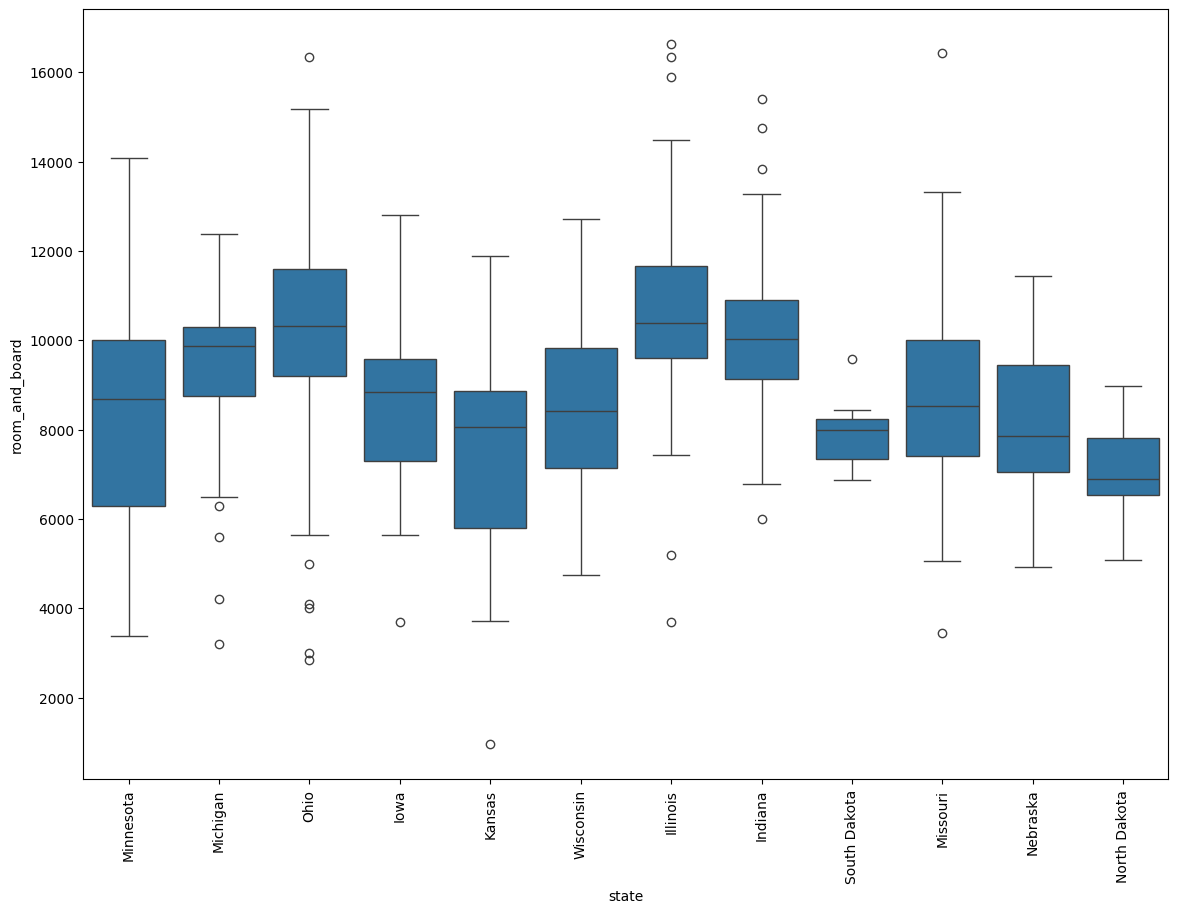

In [7]:
# association between room and board prices and the state that college is located in
plt.figure(figsize=(14,10))
sns.boxplot(data = df, x='state', y='room_and_board')
plt.xticks(rotation=90)

In [8]:
df[ df['state'] == 'Kansas'].nsmallest(1, 'room_and_board')

,name,state,type,degree_length,room_and_board,in_state_tuition,out_of_state_tuition
995,Haskell Indian Nations University,Kansas,Public,4 Year,950.0,480,480


This is not false or a implicit missing value as I checked and this school is federally funded for Indian tribes and have a low tuition and board prices.

In [9]:
# fill room_and_board missing values with the median room_and_board price of the state
df['room_and_board'] = df.groupby('state')['room_and_board'].transform(lambda x: x.fillna(x.median()))
df

,name,state,type,degree_length,room_and_board,in_state_tuition,out_of_state_tuition
3,Academy College,Minnesota,For Profit,2 Year,8689.5,17661,17661
8,Adrian College,Michigan,Private,4 Year,11318.0,37087,37087
24,Albion College,Michigan,Private,4 Year,12380.0,45775,45775
28,Alexandria Technical and Community College,Minnesota,Public,2 Year,8689.5,5416,5416
33,Allegheny Wesleyan College,Ohio,Private,4 Year,4000.0,6400,6400
...,...,...,...,...,...,...,...
2945,Xavier University,Ohio,Private,4 Year,12780.0,38530,38530
2951,Yeshiva Beth Yehuda-Yeshiva Gedolah of Greater...,Michigan,Private,4 Year,4200.0,6800,6800
2965,York College,Nebraska,Private,4 Year,7220.0,19310,19310
2970,Youngstown State University,Ohio,Public,4 Year,9400.0,8950,14950


In [10]:
df.isna().sum()

name                    0
state                   0
type                    0
degree_length           0
room_and_board          0
in_state_tuition        0
out_of_state_tuition    0
dtype: int64

## 4. Preliminary Analysis

The full model meets the linearity assumption as there is a roughly even distribution of positive and negative values as we look at small x-axis windows in fitted values vs residuals plot. The numerical variables show a mostly linear relationship with each other, so would not need a transformation in any variables. We would not have a problem with multicollinearity as the two numerical explanatory variables do not have a strong correlation.

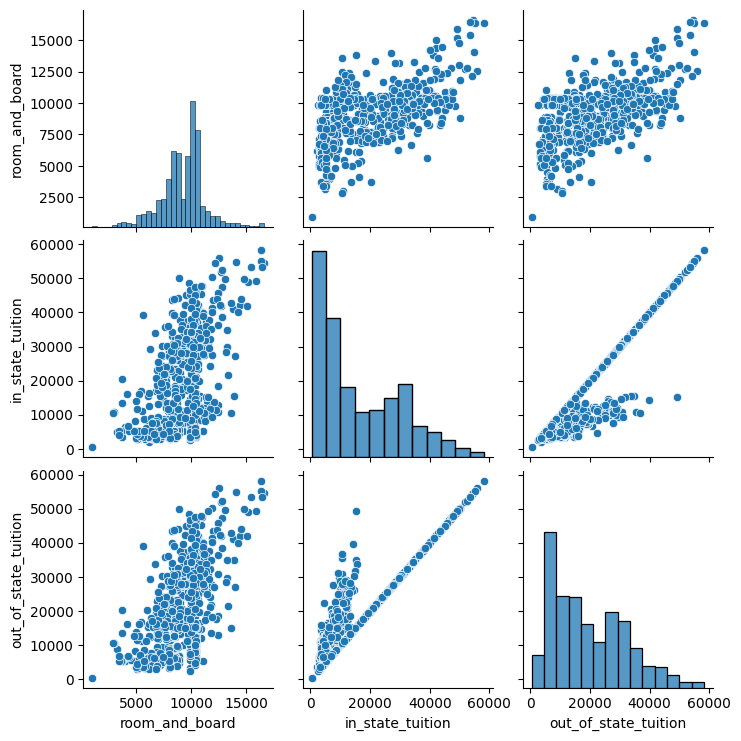

In [11]:
sns.pairplot(data=df)

In [12]:
df.corr(numeric_only=True)

,room_and_board,in_state_tuition,out_of_state_tuition
room_and_board,1.000000,0.422704,0.508158
in_state_tuition,0.422704,1.000000,0.935633
out_of_state_tuition,0.508158,0.935633,1.000000


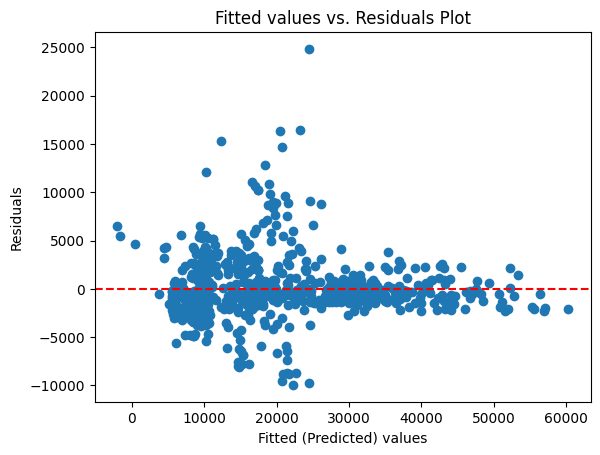

In [13]:
full_model = smf.ols(formula='out_of_state_tuition~state+type+degree_length+room_and_board+in_state_tuition', data=df).fit()
plt.scatter(full_model.fittedvalues, full_model.resid)
plt.axhline(y=0, linestyle='--', color='r')
plt.xlabel('Fitted (Predicted) values')
plt.ylabel('Residuals')
plt.title('Fitted values vs. Residuals Plot')
plt.show()

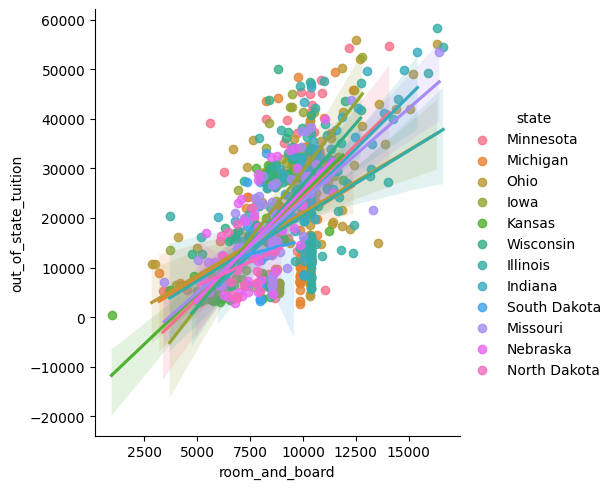

In [14]:
sns.lmplot(x='room_and_board', y='out_of_state_tuition', hue='state', data=df)

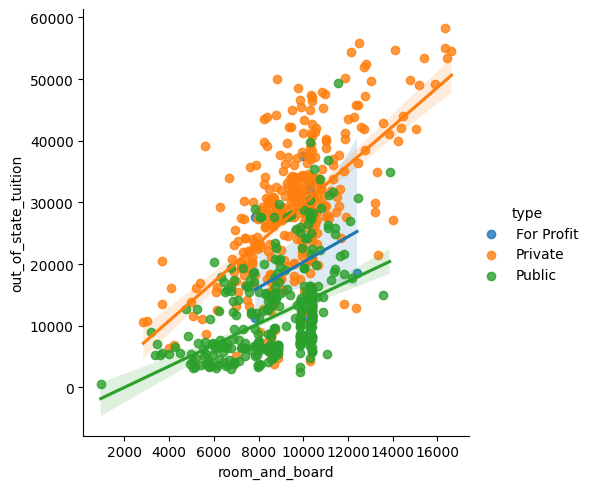

In [15]:
sns.lmplot(x='room_and_board', y='out_of_state_tuition', hue='type', data=df)

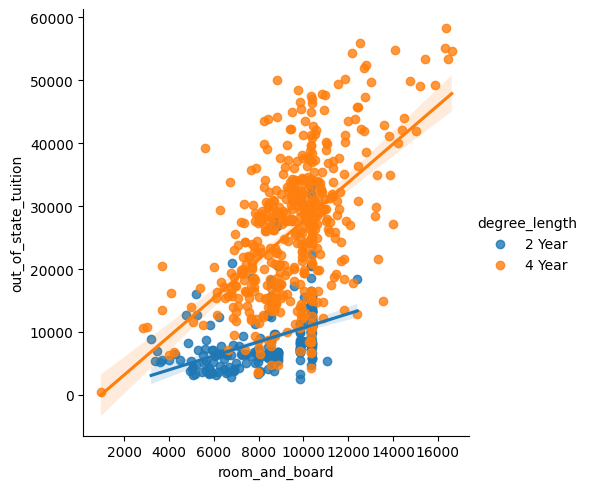

In [16]:
sns.lmplot(x='room_and_board', y='out_of_state_tuition', hue='degree_length', data=df)

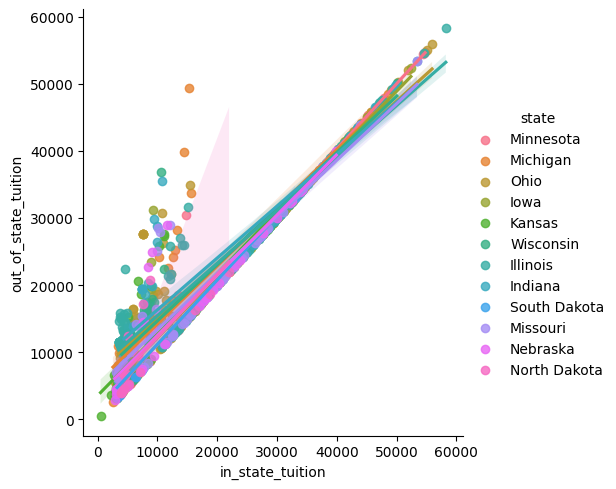

In [17]:
sns.lmplot(x='in_state_tuition', y='out_of_state_tuition', hue='state', data=df)

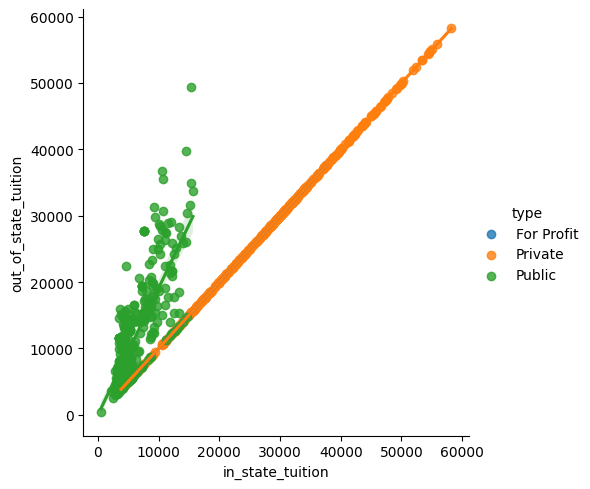

In [18]:
sns.lmplot(x='in_state_tuition', y='out_of_state_tuition', hue='type', data=df)

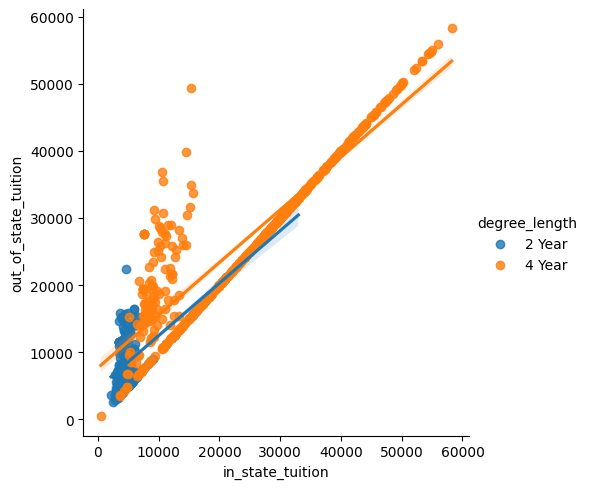

In [19]:
sns.lmplot(x='in_state_tuition', y='out_of_state_tuition', hue='degree_length', data=df)

From the plots above, the most interaction can be seen among `in_state_tuition` and `type` categorical variable, `room_and_board` with all three categorical variables. The interaction between `in_state_tuition` and `type` stands out the most as it seems like private colleges usually have similar tuition fees for instate and out-of-state students whereas public colleges show a greater difference.

## 5. Predictive Models

Splitting the cleaned dataset into training and test datasets, with test size 20%. I also standardized the two numerical variables because they had very different standard deviations, and that would have caused problem when we try interpreting the importance of the explanatory variables.

In [20]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=27)
df_test.shape[0] / df.shape[0]

0.20103092783505155

In [21]:
df_train[['in_state_tuition', 'room_and_board']].std()

in_state_tuition    13640.035715
room_and_board       1974.942410
dtype: float64

In [22]:
scalar_training = StandardScaler()
df_train[['in_state_tuition', 'room_and_board']] = scalar_training.fit_transform(df_train[['in_state_tuition', 'room_and_board']])
df_train.head()

,name,state,type,degree_length,room_and_board,in_state_tuition,out_of_state_tuition
1093,Indiana University East,Indiana,Public,4 Year,0.416049,-0.716249,19400
432,Chicago State University,Illinois,Public,4 Year,-0.245770,-0.361639,20877
2289,St. Olaf College,Minnesota,Private,4 Year,0.831586,2.255055,47840
1457,Metropolitan Community College,Nebraska,Public,2 Year,-1.496943,-1.027277,4545
1776,Ohio University,Ohio,Public,4 Year,1.328204,-0.360538,21656


In [23]:
df_test[['in_state_tuition', 'room_and_board']] = scalar_training.transform(df_test[['in_state_tuition', 'room_and_board']])
df_test.head()

,name,state,type,degree_length,room_and_board,in_state_tuition,out_of_state_tuition
1504,Minnesota State Community and Technical College,Minnesota,Public,2 Year,-2.132917,-0.861968,5358
660,Dakota College at Bottineau,North Dakota,Public,2 Year,-1.012994,-0.919932,6444
1080,Illinois Eastern Community Colleges: Olney Cen...,Illinois,Public,2 Year,0.592399,-0.981419,11008
1215,Kenyon College,Ohio,Private,4 Year,1.672796,2.848641,55930
1595,Muskingum University,Ohio,Private,4 Year,1.150840,0.837199,28516


Non-regularized linear regression full model, gives us a test R2 score of 0.9382 which is already pretty good. This is because we are also using a the `in_state_tuition` which has a very strong correlation with our response variable.

In [24]:
full_model = smf.ols(formula='out_of_state_tuition~state+type+degree_length+room_and_board+in_state_tuition', data=df_train).fit()
print('training R2', full_model.rsquared)
y_test = df_test['out_of_state_tuition']
y_pred_test = full_model.predict(df_test)
print('test R2', r2_score(y_test, y_pred_test))

training R2 0.9287842460895542
test R2 0.9382096017599503


Non-regularized linear regression full model with interaction terms, includes 4 interactions `room_and_board` with all three categorical explanatory variables, and `in_state_tuition` with just `type` variable. This model gives us a better test R2 score as compared to the full model without interaction terms.

In [25]:
full_interaction_model = smf.ols(formula='out_of_state_tuition~state+type+degree_length+room_and_board+in_state_tuition+in_state_tuition*type+room_and_board*type+room_and_board*degree_length+room_and_board*state', data=df_train).fit()
print('training R2', full_interaction_model.rsquared)
y_test = df_test['out_of_state_tuition']
y_pred_test = full_interaction_model.predict(df_test)
print('test R2', r2_score(y_test, y_pred_test))

training R2 0.9414387165058457
test R2 0.9447992130120846


I am going to perform backwards elimination algorithm to find a good combination of explanatory variables to include in a model that give the best test R2 score.

In [26]:
test_model_1 = smf.ols(formula='out_of_state_tuition~type+degree_length+room_and_board+in_state_tuition', data=df_train).fit()
print('training R2', test_model_1.rsquared)
y_test = df_test['out_of_state_tuition']
y_pred_test = test_model_1.predict(df_test)
print('test R2', r2_score(y_test, y_pred_test))

training R2 0.9242610756699431
test R2 0.9285482978558841


In [27]:
test_model_2 = smf.ols(formula='out_of_state_tuition~state+degree_length+room_and_board+in_state_tuition', data=df_train).fit()
print('training R2', test_model_2.rsquared)
y_test = df_test['out_of_state_tuition']
y_pred_test = test_model_2.predict(df_test)
print('test R2', r2_score(y_test, y_pred_test))

training R2 0.9004891546849163
test R2 0.9182776860844154


In [28]:
test_model_3 = smf.ols(formula='out_of_state_tuition~state+type+room_and_board+in_state_tuition', data=df_train).fit()
print('training R2', test_model_3.rsquared)
y_test = df_test['out_of_state_tuition']
y_pred_test = test_model_3.predict(df_test)
print('test R2', r2_score(y_test, y_pred_test))

training R2 0.9090022390818931
test R2 0.9365059861252467


In [29]:
test_model_4 = smf.ols(formula='out_of_state_tuition~state+type+degree_length+in_state_tuition', data=df_train).fit()
print('training R2', test_model_4.rsquared)
y_test = df_test['out_of_state_tuition']
y_pred_test = test_model_4.predict(df_test)
print('test R2', r2_score(y_test, y_pred_test))

training R2 0.9269087518571985
test R2 0.9360138113357153


In [30]:
test_model_5 = smf.ols(formula='out_of_state_tuition~state+type+degree_length+room_and_board', data=df_train).fit()
print('training R2', test_model_5.rsquared)
y_test = df_test['out_of_state_tuition']
y_pred_test = test_model_5.predict(df_test)
print('test R2', r2_score(y_test, y_pred_test))

training R2 0.6861133189812176
test R2 0.7101664474687326


None of these test models have a better test R2 than the full models. The full model with interaction terms had the best test R2 score of 0.9448 among all the models.

## 6. Best Model Discussion

In [31]:
full_interaction_model = smf.ols(formula='out_of_state_tuition~state+type+degree_length+room_and_board+in_state_tuition+in_state_tuition*type+room_and_board*type+room_and_board*degree_length+room_and_board*state', data=df_train).fit()
full_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     out_of_state_tuition   R-squared:                       0.941
Model:                              OLS   Adj. R-squared:                  0.938
Method:                   Least Squares   F-statistic:                     294.9
Date:                  Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                          22:30:41   Log-Likelihood:                -5848.6
No. Observations:                   620   AIC:                         1.176e+04
Df Residuals:                       587   BIC:                         1.191e+04
Df Model:                            32                                         
Covariance Type:              nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               1.688e+04    983.425     17.164      0.000    1.49e+04    1.88e+04
state[T.Indiana]                        1604.6097    659.886      2.432      0.015     308.584    2900.635
state[T.Iowa]                           -263.1838    674.684     -0.390      0.697   -1588.272    1061.904
state[T.Kansas]                          346.9332    739.473      0.469      0.639   -1105.401    1799.267
state[T.Michigan]                       -509.2009    593.914     -0.857      0.392   -1675.655     657.253
state[T.Minnesota]                     -2193.8236    630.624     -3.479      0.001   -3432.378    -955.269
state[T.Missouri]                        266.4448    624.948      0.426      0.670    -960.961    1493.850
state[T.Nebraska]                        235.8277    860.991      0.274      0.784   -1455.171    1926.826
state[T.North Dakota]                  -2803.5440   2084.173     -1.345      0.179   -6896.889    1289.801
state[T.Ohio]                            183.4908    535.354      0.343      0.732    -867.953    1234.934
state[T.South Dakota]                  -2543.6322   1973.808     -1.289      0.198   -6420.219    1332.954
state[T.Wisconsin]                       524.8307    650.983      0.806      0.420    -753.709    1803.371
type[T.Private]                        -1268.8117    940.769     -1.349      0.178   -3116.494     578.871
type[T.Public]                          1.311e+04   1349.740      9.716      0.000    1.05e+04    1.58e+04
degree_length[T.4 Year]                 1768.2074    507.916      3.481      0.001     770.653    2765.761
room_and_board                           -10.2688   1442.046     -0.007      0.994   -2842.466    2821.929
room_and_board:type[T.Private]           -28.9021   1449.870     -0.020      0.984   -2876.467    2818.662
room_and_board:type[T.Public]           1342.8813   1421.283      0.945      0.345   -1448.538    4134.301
room_and_board:degree_length[T.4 Year]   -81.2340    413.093     -0.197      0.844    -892.554     730.087
room_and_board:state[T.Indiana]         -933.3701    670.753     -1.392      0.165   -2250.737     383.997
room_and_board:state[T.Iowa]            1086.2808    752.873      1.443      0.150    -392.373    2564.934
room_and_board:state[T.Kansas]           268.9732    684.313      0.393      0.694   -1075.027    1612.973
room_and_board:state[T.Michigan]         191.3821    678.399      0.282      0.778   -1141.002    1523.766
room_and_board:state[T.Minnesota]        -43.5799    667.806     -0.065      0.948   -1355.160    1268.000
room_and_board:state[T.Missouri]         -32.6489    609.099     -0.054      0.957   -1228.927    1163.630
room_and_board:state[T.Nebraska]        1214.4387    954.871     

The best model that yielded the highest test R2 score is the non-regularized full model with interaction terms. We found the test R2 score of 0.9448 which is really good. The interaction terms it tough properly interpret from the slopes corresponding to all explanatory variables. Hence choosing the full model without interaction terms would not be a much worse option either as its test R2 score was 0.9382. This test R2 score was still better than other test models. We could trade off some test R2 score for better interpretability.

In [32]:
full_model = smf.ols(formula='out_of_state_tuition~state+type+degree_length+room_and_board+in_state_tuition', data=df_train).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     out_of_state_tuition   R-squared:                       0.929
Model:                              OLS   Adj. R-squared:                  0.927
Method:                   Least Squares   F-statistic:                     491.5
Date:                  Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                          22:30:41   Log-Likelihood:                -5909.2
No. Observations:                   620   AIC:                         1.185e+04
Df Residuals:                       603   BIC:                         1.193e+04
Df Model:                            16                                         
Covariance Type:              nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1.592e+04    955.841     16.655      0.000     1.4e+04    1.78e+04
state[T.Indiana]          652.6118    583.744      1.118      0.264    -493.806    1799.030
state[T.Iowa]            -605.6961    653.652     -0.927      0.354   -1889.407     678.015
state[T.Kansas]         -1008.2853    656.832     -1.535      0.125   -2298.242     281.671
state[T.Michigan]        -304.0213    569.072     -0.534      0.593   -1421.625     813.583
state[T.Minnesota]      -2082.5680    607.225     -3.430      0.001   -3275.102    -890.035
state[T.Missouri]        -136.9009    593.502     -0.231      0.818   -1302.483    1028.681
state[T.Nebraska]        -890.7164    774.326     -1.150      0.250   -2411.419     629.986
state[T.North Dakota]   -2345.4250   1041.586     -2.252      0.025   -4391.003    -299.847
state[T.Ohio]             -85.4768    477.228     -0.179      0.858   -1022.709     851.755
state[T.South Dakota]   -4144.5340   1062.144     -3.902      0.000   -6230.485   -2058.583
state[T.Wisconsin]         58.8422    603.857      0.097      0.922   -1127.076    1244.760
type[T.Private]         -2498.7994    929.317     -2.689      0.007   -4323.890    -673.709
type[T.Public]           5387.7391    946.038      5.695      0.000    3529.810    7245.668
degree_length[T.4 Year]  4832.8158    373.417     12.942      0.000    4099.459    5566.172
room_and_board            737.7841    185.140      3.985      0.000     374.186    1101.382
in_state_tuition         1.295e+04    285.583     45.329      0.000    1.24e+04    1.35e+04
==============================================================================
Omnibus:                      252.782   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1966.307
Skew:                           1.612   Prob(JB):                         0.00
Kurtosis:                      11.107   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$
\begin{aligned}
\hat{\text{out\_of\_state\_tuition}} \ 
&= 15920 \\
&+ 652.61 \cdot \text{state}_{{Indiana}} \\
&- 605.70 \cdot \text{state}_{{Iowa}} \\
&- 1008.29 \cdot \text{state}_{{Kansas}} \\
&- 304.02 \cdot \text{state}_{{Michigan}} \\
&- 2082.57 \cdot \text{state}_{{Minnesota}} \\
&- 136.90 \cdot \text{state}_{{Missouri}} \\
&- 890.72 \cdot \text{state}_{{Nebraska}} \\
&- 2345.43 \cdot \text{state}_{{North Dakota}} \\
&- 85.48 \cdot \text{state}_{{Ohio}} \\
&- 4144.53 \cdot \text{state}_{{South Dakota}} \\
&+ 58.84 \cdot \text{state}_{{Wisconsin}} \\
&- 2498.80 \cdot \text{type}_{{Private}} \\
&+ 5387.74 \cdot \text{type}_{{Public}} \\
&+ 4832.82 \cdot \text{degree\_length}_{{4-Year}} \\
&+ 737.78 \cdot \text{room\_and\_board} \\
&+ 12950 \cdot \text{in\_state\_tuition}
\end{aligned}
$$


After performing feature selection we found that none of the explanatory variables were causing overfitting and from previous correlation matrix we can also confirm that the model likely does not have a issue of multicollinearity as the only pair of numerical explanatory variable did not have a strong correlation.

Because of the standization we performed earlier, we can confidently interpret which numerical variable holds the most predictive power and which holds the least among the 2 numerical explanatory variables we used in the model. <br>
Most predictive power: in_state_tuition as it has the higher slope magnitude <br>
second most/least predictive power: room_and_board as it has the lower slope magnitude as compared to in_state_tuition.

## 7. Conclusion

The full model without interaction terms satisfies both primary and secondary goals, and the full model with interaction terms satisfies the primary goal of making a predictive model with a better R2 than the model without interaction terms. The users of this predictive model can use either model depending on their specific need. If the user is trying to evaluate and shortlist options for higher education, they should use the full model without interaction terms as it has better interpretability of slopes, which can better help the user understand tradeoffs according to their financial plan. If a parent/student is looking to get a estimate for how much higher education will be costing them, they can use the model with interaction terms, as it gives a better estimate.

Some shortcomings in this project are that, we had to limit the colleges to only the ones in midwestern area of U.S. because of the categorical variable complexity. In future we can make a model for every state, maybe narrow it down to only public universities and they show a larger difference in in-state and out-of-state tuition rates. Some important factors such as school size, school rankings, acceptance rate, urban vs rural setting, demographics were not included but could be important information for the user. We had some missing data in room_and_board column, I chose to fill it in with median price of the state, we could have removed the colleges which did not have a option for room_and_board. In future, the model can be made better to include more states, more features, more updated dataset with latest cost of tuition and on-campus housing.